In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sklearn

In [86]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


### 除去异常值

In [87]:
# 删除'GrLivArea'最大且和'SalePrice'不成正比的两个'Id'
train = train[~((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))]

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

# 删除一些特征
all_data.drop(['1stFlrSF', 'GarageArea', 'TotRmsAbvGrd','1stFlrSF','Street'], axis=1, inplace=True)

In [88]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [89]:
from scipy.stats import skew
from scipy.special import boxcox1p
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.65]
skewed_feats = skewed_feats.index

lam=0.14
all_data[skewed_feats] = boxcox1p(all_data[skewed_feats],lam)

In [90]:
# 标准化数据
all_data = pd.get_dummies(all_data)

In [91]:
all_data = all_data.fillna(all_data.mean())

建立一个线性模型
* 我们将分离功能和目标变量进行建模。

In [92]:
traindata = all_data[:train.shape[0]]
testdata = all_data[train.shape[0]:]
y = train.SalePrice

## 使用scikit-learn的train_test_split()功能来创建一个训练集和一个保留集

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(
                                    traindata, y, random_state=42, test_size=.33)

In [94]:
from sklearn.model_selection import cross_val_score
# 定义一个函数方便计算每个模型的交叉验证的rmse
def rmse_cv(model,X_train,y):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, 
                                    scoring="neg_mean_squared_error",
                                   cv = 5))
    return rmse

In [95]:
# 定义一个画图显示最佳参数的函数
def show_rule(models, alphas):
    cv_models = [rmse_cv(models(alpha = alpha),X_train, y_train).mean() for alpha in alphas]
    print(cv_models)
    cv_models = pd.Series(cv_models, index = alphas)
    cv_models.plot()
    plt.show()

实例化一个线性回归模型

* `RMSE`：测量我们的预测值和实际值之间的距离

In [96]:
from sklearn.linear_model import Ridge 
# 拟合模型
#alphas = [1,3,5,10,15,20,30]
#show_rule(Ridge, alphas)

另一个模型

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

[0.13192631249016984, 0.12893304641243911, 0.12525664310120502, 0.12121188422707521, 0.11780239227457964, 0.11538962306245928, 0.11401987162791132, 0.11289298124529427, 0.11341715043985996, 0.11489698343822545]


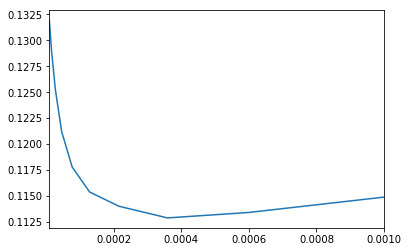

In [97]:
from sklearn.linear_model import Lasso

alphas = np.logspace(-5,-3,10)
show_rule(Lasso, alphas)

In [128]:
lasso = Lasso(alpha=0.00038)
model = lasso
model = model.fit(traindata, y)

## 提交
我们需要创建一个csv包含数据集中SalePrice每个观测值的预测值test.csv。

In [129]:
predictions = np.expm1(model.predict(testdata))

In [130]:
print ("Original predictions are: \n", predictions[:5], "\n")

Original predictions are: 
 [ 117373.55574082  154543.9361995   184113.02977269  199615.33841765
  196206.34958031] 



In [131]:
solution = pd.DataFrame({"Id":test.Id, "SalePrice":predictions})

保存预测结果到`csv`文件

In [132]:
solution.to_csv("full_features_lasso.csv", index = False)

[提交页面](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit)